# Predicting Number of Oscar Nominations for a Movie

Topic | Date | Name
-----|------|-----
Explore boxofficemojo data |04/14/2016 |Max Melnick

**Data to collect**
- number of days released befor oscar nominations are announced
- imdb critic rating
- imdb user rating
- number of nominations
- number of wins
- actors (not sure how to structure this. maybe # top actors/actresses?)
- collective previous oscar nominations/wins for cast??
- total gross


**Completed**
- production budget
- genre
- international gross
- opening weekend gross
- studio
- \# theaters

Other ideas:
- optimal years/days to wait to release a sequel
- optimal # weeks to wait to see a popular movie

---

In [5]:
import requests
from bs4 import BeautifulSoup
import re
from pprint import pprint
import pandas as pd
from pandas import DataFrame
import numpy as np
import datetime
from time import strftime
from math import ceil
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style('whitegrid')

from matplotlib.ticker import FuncFormatter

%matplotlib inline

import gevent.monkey
gevent.monkey.patch_socket()
from gevent.pool import Pool

import dateutil.parser

In [6]:
base_url = 'http://boxofficemojo.com'

In [28]:
import time

def timefunc(f):
    def f_timer(*args, **kwargs):
        start = time.time()
        result = f(*args, **kwargs)
        end = time.time()
        print f.__name__, 'took', end - start, 'time'
        return result
    return f_timer

In [32]:
def urlToSoup(url):
    response = requests.get(url)
    return BeautifulSoup(response.text, 'lxml')

def to_date(datestring):
    date = dateutil.parser.parse(datestring)
    return date

def money_to_int(moneystring):
    try:
        moneystring = moneystring.replace(' (Estimate)', '')
        moneystring = moneystring.replace('$', '').replace(',', '')
        return int(moneystring)
    except:
        return None

def runtime_to_minutes(runtimestring):
    runtime = runtimestring.split()
    try:
        minutes = int(runtime[0])*60 + int(runtime[2])
        return minutes
    except:
        return None

def budgetToInt(budget_string):
    budget_list = budget_string.replace('$','').split(' ')
    # when the movie budget is a string in form $XX million
    if len(budget_list) > 1:
        budget = int(float(budget_list[0])*1000000)
        return budget
    # when budget is a string like $100,000
    elif budget_list[0].lower() != 'n/a':
        budget = budget_list[0].replace(',','')
        return money_to_int(budget)
    # when budget is a string == 'N/A' or not listed
    else:
        return None

def getNumTheaters(raw_theater_string):
    theater_string = str(raw_theater_string)
    theater_string = re.search('(\d+,?\d+)+ theaters', theater_string)
    if theater_string:
        theater_string = theater_string.group(0).replace(',','').split(' ')
        return int(theater_string[0])
    else:
        return None
        

def get_movie_value(soup, field_name):
    '''Grab a value from boxofficemojo HTML
    
    Takes a string attribute of a movie on the page and
    returns the string in the next sibling object
    (the value for that attribute)
    or None if nothing is found.
    '''
    obj = soup.find(text=re.compile(field_name))
    if not obj: 
        return None
    in_box_content = obj.find_parents(class_='mp_box_content')
    if in_box_content:
        return getBoxContent(obj)
    else:
        return getHeadTableContent(obj)
    

def getHeadTableContent(obj):
    next_sibling = obj.findNextSibling()
    parent_sibling = obj.find_parent().findNextSibling()
    if next_sibling:
        return next_sibling.text 
    elif parent_sibling:
        return parent_sibling.text
    else:
        return None
    
def getBoxContent(obj):
    next_td = obj.find_parent('td').find_next_sibling('td')
    if next_td:
        return next_td.get_text(strip=True)
    else:
        return getNumTheaters(obj)

def getSingleMovieData(url):
    #create a blank dictionary that will be used to track the movie data
    movie_data = {}
    
    #get the raw movie HTML and create a BeautifulSoup object with the text
    soup = urlToSoup(url)
    
    movie_data['url'] = url
    
    #get the movie director and add it to `movie_data` dictionary
    movie_data['director'] = get_movie_value(soup, 'Director')

    #get the movie title
    title_string = soup.find('title').text
    title = title_string.split('(')[0].strip()
    movie_data['title'] = title
    
    #get the release date
    raw_release_date = get_movie_value(soup,'Release Date')
    movie_data['release_date'] = to_date(raw_release_date)
    
    #get the domestic total gross
    raw_domestic_total_gross = get_movie_value(soup,'Domestic Total')
    movie_data['domestic_total_gross'] = money_to_int(raw_domestic_total_gross)
    
    # foreign gross
    movie_data['foreign_total_gross'] = money_to_int(get_movie_value(soup, 'Foreign:'))
    
    #get the MPAA rating
    movie_data['rating'] = get_movie_value(soup,'MPAA Rating')
    
    # get runtime and convert it to an int
    raw_runtime = get_movie_value(soup,'Runtime')
    movie_data['runtime'] = runtime_to_minutes(raw_runtime)
    
    # get genre
    movie_data['genre'] = get_movie_value(soup,'Genre:')

    # get production budget
    raw_budget = get_movie_value(soup,'Production Budget')    
    movie_data['budget'] = budgetToInt(raw_budget)
    
    # opening weekend
    movie_data['opening_weekend_gross'] = money_to_int(get_movie_value(soup, 'Weekend:'))
    
    # studio
    movie_data['studio'] = get_movie_value(soup, 'Distributor:')
    
    # num opening weekend theaters
    movie_data['num_opening_theaters'] = get_movie_value(soup, 'theaters,')
    
    return movie_data

@timefunc
def getAllMovieData(urls):
    links_to_movies = []
    for url in urls:
        links_to_movies += urlToSoup(url).find(id='body').find_all('a', href=re.compile('^/movies/\?id'))

    data = []
    
    for i in links_to_movies:
        url = base_url+i.get('href')
        movie_data = getSingleMovieData(url)
        data.append(movie_data)
    return data
        

def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.0fM' % (x*1e-6)

formatter = FuncFormatter(millions)

In [13]:
def getSingleMovieData2(soup):
    #create a blank dictionary that will be used to track the movie data
    movie_data = {}
    
    #movie_data['url'] = url
    
    #get the movie director and add it to `movie_data` dictionary
    movie_data['director'] = get_movie_value(soup, 'Director')

    #get the movie title
    title_string = soup.find('title').text
    title = title_string.split('(')[0].strip()
    movie_data['title'] = title
    
    #get the release date
    raw_release_date = get_movie_value(soup,'Release Date')
    movie_data['release_date'] = to_date(raw_release_date)
    
    #get the domestic total gross
    raw_domestic_total_gross = get_movie_value(soup,'Domestic Total')
    movie_data['domestic_total_gross'] = money_to_int(raw_domestic_total_gross)
    
    # foreign gross
    movie_data['foreign_total_gross'] = money_to_int(get_movie_value(soup, 'Foreign:'))
    
    #get the MPAA rating
    movie_data['rating'] = get_movie_value(soup,'MPAA Rating')
    
    # get runtime and convert it to an int
    raw_runtime = get_movie_value(soup,'Runtime')
    movie_data['runtime'] = runtime_to_minutes(raw_runtime)
    
    # get genre
    movie_data['genre'] = get_movie_value(soup,'Genre:')

    # get production budget
    raw_budget = get_movie_value(soup,'Production Budget')    
    movie_data['budget'] = budgetToInt(raw_budget)
    
    # opening weekend
    movie_data['opening_weekend_gross'] = money_to_int(get_movie_value(soup, 'Weekend:'))
    
    # studio
    movie_data['studio'] = get_movie_value(soup, 'Distributor:')
    
    # num opening weekend theaters
    movie_data['num_opening_theaters'] = get_movie_value(soup, 'theaters,')
    
    return movie_data

In [49]:
def getMoviePages(urls):
    pool = Pool(50)
    results = []
    for url in urls:
        results.append(pool.spawn(urlToSoup, base_url+url.get('href')))
    pool.join()
    return results

@timefunc
def getAllMovieData2(year_urls):
    links_to_movies = []
    for url in year_urls:
        links_to_movies += urlToSoup(url).find(id='body').find_all('a', href=re.compile('^/movies/\?id'))
    
    movies = getMoviePages(links_to_movies)
    
    data = []
    for movie in movies:
        movie_data = getSingleMovieData2(movie.value)
        data.append(movie_data)
    return data

In [50]:
#list the years that we want to get data for the top 100 movies of each year
#years = ['2012', '2013','2014','2015']
years = ['2015']

#generate the urls that we'll scrape for each year on boxofficemojo.com
year_urls = []
for year in years:
    year_urls.append('http://www.boxofficemojo.com/yearly/chart/?yr='+year+'&p=.htm')

movie_data = getAllMovieData(year_urls)

a_data = getAllMovieData2(year_urls)

getAllMovieData took 25.1342768669 time
getAllMovieData2 took 5.73812890053 time


In [160]:
movie_df = DataFrame(movie_data)

movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 13 columns):
budget                   350 non-null float64
director                 377 non-null object
domestic_total_gross     400 non-null int64
foreign_total_gross      390 non-null float64
genre                    400 non-null object
num_opening_theaters     374 non-null float64
opening_weekend_gross    400 non-null int64
rating                   400 non-null object
release_date             400 non-null datetime64[ns]
runtime                  400 non-null int64
studio                   400 non-null object
title                    400 non-null object
url                      400 non-null object
dtypes: datetime64[ns](1), float64(3), int64(3), object(6)
memory usage: 40.7+ KB


**Challenge 1**

Plot domestic total gross over time.

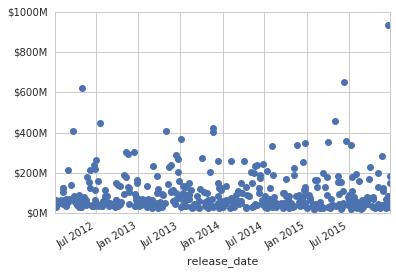

In [60]:
ax = movie_df.plot(x='release_date',y='domestic_total_gross', style='o')
ax.legend_.remove()
ax.yaxis.set_major_formatter(formatter)

**Challenge 2**

Plot runtime vs. domestic total gross.

(0, 1000000000.0)

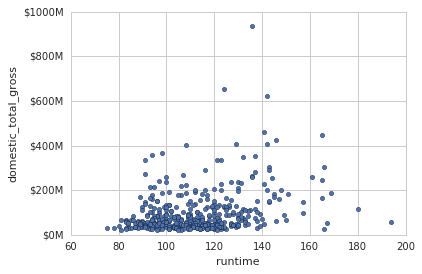

In [7]:
ax = movie_df.plot(x='runtime',y='domestic_total_gross', kind='scatter')
ax.yaxis.set_major_formatter(formatter)
ax.set_ylim(bottom=0)

**Challenge 3**

Group your data by Rating and find the average runtime and domestic total gross at each level of Rating.

In [58]:
rating_grp = movie_df.groupby(by=['rating'])
print rating_grp.aggregate(np.mean)

        domestic_total_gross     runtime
rating                                  
G               9.742439e+07   93.857143
PG              1.117879e+08  101.594595
PG-13           1.160606e+08  117.732240
R               7.209765e+07  112.375000


**Challenge 4**

Make one figure with (N=the number of MPAA ratings there are) subplots, and in each plot the release date vs the domestic total gross.

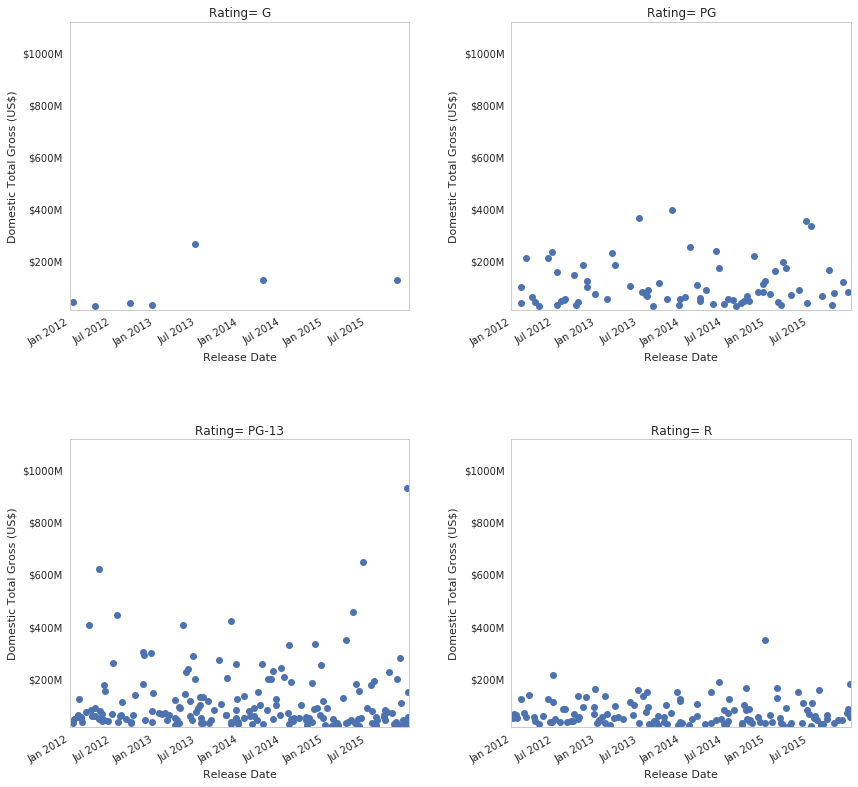

In [24]:
rating_grp_list = []
for name, grp in rating_grp:
    rating_grp_list.append([name, grp])

fig, axes = plt.subplots(nrows=int(ceil(float(len(rating_grp_list))/2)), ncols=2, figsize=(14,14))

plt.subplots_adjust(wspace=0.3,hspace=0.45)

#calculate the min and max for the x and y axes, including some buffer in each so the plots
#don't look too tight
time_delta = datetime.timedelta(days=5)
datemin = movie_df['release_date'].min() - time_delta
datemax = movie_df['release_date'].max() + time_delta

dtgmin = movie_df['domestic_total_gross'].min()*.8
dtgmax = movie_df['domestic_total_gross'].max()*1.2

xlim = (datemin, datemax)
ylim = (dtgmin, dtgmax)

#go through and plot each the domestic total gross data by rating and date on each axes
count = 0
for ax in axes:
    for a in ax:
        if count < len(rating_grp_list):
            rating_grp_list[count][1].plot(x='release_date', y='domestic_total_gross', ax=a,
                  grid=False, marker='o', linestyle='None', title='Rating= '+rating_grp_list[count][0])
            a.set_xlabel("Release Date")
            a.set_ylabel("Domestic Total Gross (US\$)")
            a.set_xlim(xlim)
            a.set_ylim(ylim)
            a.legend_.remove()
            a.yaxis.set_major_formatter(formatter)
            count += 1

**Challenge 5**

What director in your dataset has the highest gross per movie?

In [11]:
director_grp = movie_df.groupby(by='director')
director_gross = director_grp['domestic_total_gross'].mean()
director_gross.sort_values(inplace=True, ascending=False)
print director_gross[:1]

director
Colin Trevorrow    652270625
Name: domestic_total_gross, dtype: int64


**Challenge 6**

Bin your dataset into months and make a bar graph of the mean domestic total gross by month.  Error bars will represent the standard error of the mean.

Title of graph should include:  Mean Domestic Total Gross by Month in 2013

Topic for consideration:  what is the correct formula for the standard error of the mean?  Examine the error bars and see if they are "reasonable."

In [12]:
def convertToMonth(dt):
    return dt.strftime('%Y-%m')

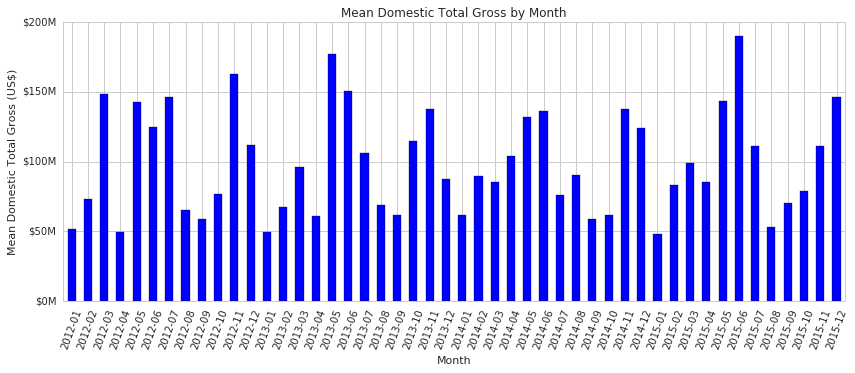

In [13]:
movie_df['month'] = movie_df['release_date'].map(convertToMonth)
month_grp = movie_df.groupby(by='month')
mean_month_grp = month_grp['domestic_total_gross'].mean()

fig, ax = plt.subplots(figsize=(14,5))
mean_month_grp.plot(kind='bar', title='Mean Domestic Total Gross by Month', ax=ax)
plt.xticks(rotation=70)
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel('Month')
ax.set_ylabel('Mean Domestic Total Gross (US\$)')

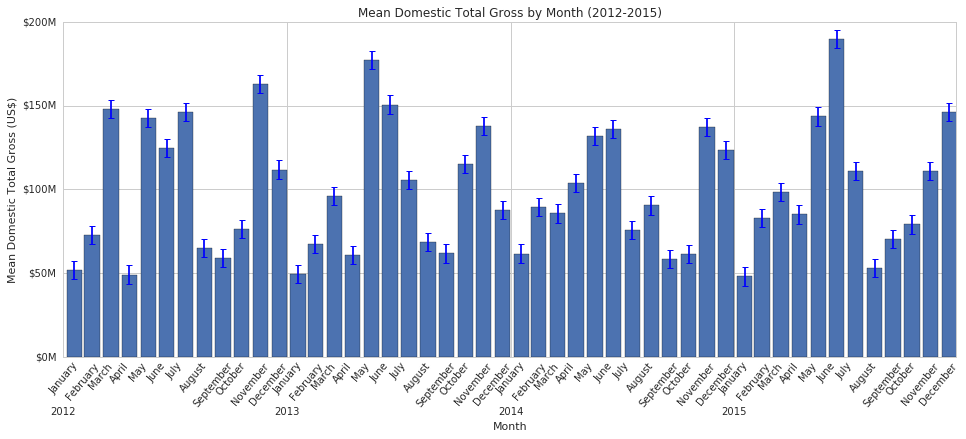

In [56]:
#group the data by release_date months and take the mean of each month
month_grp2 = movie_df.groupby([pd.Grouper(freq='1M',key='release_date')]).mean()

#get the standard error of the mean for the domestic_total_gross
sem = stats.sem(month_grp2['domestic_total_gross'])

#plot domestic total gross, grouped by month; use standard error of the mean for yerrorbars;
#include additional styling to properly align the plot
fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(month_grp2.index, month_grp2['domestic_total_gross'], width=-25, align='edge', 
       yerr=sem, error_kw={'ecolor':'b', 'capthick':1})
#format the plot
ax.set_title('Mean Domestic Total Gross by Month ('+min(years)+'-'+max(years)+')')

#format the xaxis

#use years as the major xaxis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())
#use months as the minor xaxis
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%B'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
#set the xaxis label
ax.set_xlabel('Month')
#set the limits for the xaxis to the previously calculated xlim tuple
ax.set_xlim(xlim)
#configure location/rotation of xaxis minor and major ticks
plt.setp(ax.xaxis.get_minorticklabels(), rotation=50)
plt.setp(ax.xaxis.get_majorticklabels(), multialignment='center')
ax.xaxis.set_tick_params(which='major', pad=50)

#format the yaxis

#format the yaxis so it handles 
ax.yaxis.set_major_formatter(formatter)
#set the yaxis label
ax.set_ylabel('Mean Domestic Total Gross (US\$)')